<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 6:  Web Scraping
### Finding Underpriced RVs on Craigslist

![](https://snag.gy/WrdUMx.jpg)

In this project we will be practicing our web scraping skills.  You can use Scrapy or Python requests in order to complete this project.  It may be helpful to write some prototype code in this notebook to test your assumptions, then move it into a Python file that can be run from the command line.

> In order to run code from the command line, instead of the notebook, you just need to save your code to a file (with a .py extension), and run it using the Python interpreter:<br><br>
> `python my_file.py`

You will be building a process to scrape a single category of search results on Craigslist, that can easily be applied to other categories by changing the search terms.  The main goal is to be able to target and scrape a single page given a set of parameters.

**If you use Scrapy, provide your code in a folder.**

## Import your libraries for scrapy / requests / pandas / numpy / etc
Setup whichever libraries you need. Review past material for reference.

In [1]:
# PREPARE REQUIRED LIBRARIES
import scrapy
import requests
from lxml import html
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl

%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1.  Scrape for the largest US cities (non-exhaustive list)
Search, research, and scrape Wikipedia for a list of the largest US cities.  There are a few sources but find one that is in a nice table.  We don't want all cities, just signifficant cities.  Examine your source.  Look for what can be differentiable.

- Use requests
- Build XPath query(ies)
- Extract to a list
- Clean your list

In [12]:
# SCRAPE WIKIPEDIA FOR LARGEST US CITIES (NON-EXHAUSTIVE LIST)

page = requests.get('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population')
page_ = html.fromstring(page.content)
table = page_.xpath('//tr/td[2]//a/text()')
pop = page_.xpath('//tr/td[4]/text()')
city_states = page_.xpath("//tr/td[3]//a/text()")
#//table[@class="wikitable sortable jquery-tablesorter"][1]/tbody//td[2]/text()

ConnectionError: HTTPSConnectionPool(host='en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_United_States_cities_by_population (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa8426c4790>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [3]:
cities = pd.DataFrame(table)
pop_ = pd.DataFrame(pop)
states_df = pd.DataFrame(city_states)

NameError: name 'table' is not defined

In [4]:
def clean_df(row):
    if row[0] == '[':
        return  np.nan
    else:
        return row

In [5]:
cities[0] = cities[0].apply(clean_df)

In [6]:
states_df.shape

(306, 1)

In [7]:
len(cities)

390

In [8]:
pop_.shape

(345, 1)

In [9]:
cities.dropna(inplace=True)

cities.reset_index(inplace=True)

cities.drop("index", axis=1, inplace=True)

In [10]:
cities.shape

(353, 1)

In [11]:
cities = cities[:100]

In [12]:
pop_ = pop_[:100]

In [13]:
cities.head()

,0
0,New York
1,Los Angeles
2,Chicago
3,Houston
4,Philadelphia


In [14]:

pop_.head()

,0
0,"8,550,405"
1,"3,971,883"
2,"2,720,546"
3,"2,296,224"
4,"1,567,442"


In [15]:
states_df = states_df[:100]

In [16]:
dicttodataf = {
    'City' : cities[0],
    'State' : states_df[0]
}

newdf = pd.DataFrame(dicttodataf)

In [17]:
newdf.head()

,City,State
0,New York,New York
1,Los Angeles,California
2,Chicago,Illinois
3,Houston,Texas
4,Philadelphia,Pennsylvania


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1.2 Only retain cities with properly formed ASCII

Optionally, filter out any cities with impropper ASCII characters.  A smaller list will be easier to look at.  However you may not need to filter these if you spend more time scraping a more concise city list.  This list should help you narrow down the list of regional Craigslist sites.

In [18]:
# ONLY RETAIN PROPERLY FORMED CITIES WITH FILTERING FUNCTION
def is_ascii(s):
    return all(ord(c) != 91 and ord(c) < 128 for c in s)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2.  Write a function to capture current pricing information via Craigslist in one city.
Choose a city from your scraped data, then go to the cooresponding city section on Craigslist, searching for "rv" in the auto section.  Write a method that pulls out the prices.

In [19]:
page = requests.get('http://houston.craigslist.org/search/sss?query=rv')
page_ = html.fromstring(page.text)
row_prices= page_.xpath("//span[@class='l2']/span[@class='price']/text()")


prices_df = pd.DataFrame(row_prices)

In [20]:
prices_df.head()

,0
0,$600
1,$17995
2,$1
3,$12988
4,$17995


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2.1 Create a mapping of cities to cooresponding regional Craigslist URLs

Major US cities on Craigslist typically have their own cooresponding section (ie: SFBay Area, NYC, Boston, Miami, Seattle, etc).  Later, you will use these to query search results for various metropolitian regions listed on Craigslist.  Between the major metropolitan Craigslist sites, the only thing that will differ is the URL's that correspond to them.

The point of the "mapping":  Create a data structure that allows you to iterate with both the name of the city from Wikipedia, with the cooresponding variable that that will allow you to construct each craigslist URL for each region.

> For San Francsico (the Bay Area metropolitan area), the url for the RV search result is:
> http://sfbay.craigslist.org/search/sss?query=rv
>
> The convention is http://[region].craigslist.org/search/sss?query=rf
> Replacing [region] with the cooresponding city name will allow you to quickly iterate through each regional Craigslist site, and scrape the prices from the search results.  Keep this in mind while you build this "mapping".


In [21]:
import cStringIO
def create_cl_links_(passed_list):
    for x in passed_list:
        appenderstring = x.replace(" ", "")
        appenderstring = appenderstring.lower()
        appenderstring = appenderstring.replace('.', '')
        appenderstring = appenderstring.encode("ascii","ignore")
        string_to_return = 'http://' + appenderstring + '.craigslist.org/search/sss?query=rv'
    return string_to_return

In [22]:
def create_cl_links(passed_list):
    appenderstring = passed_list.replace(" ", "")
    appenderstring = appenderstring.lower()
    appenderstring = appenderstring.replace('.', '')
    appenderstring = appenderstring.encode("ascii","ignore")
    string_to_return = 'http://' + appenderstring + '.craigslist.org/search/sss?query=rv'
    return string_to_return

In [23]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
0    100 non-null object
dtypes: object(1)
memory usage: 872.0+ bytes


In [24]:
cities.head()

,0
0,New York
1,Los Angeles
2,Chicago
3,Houston
4,Philadelphia


In [25]:
listofcllinks = create_cl_links(cities[0].values)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [26]:
listofcllinks

NameError: name 'listofcllinks' is not defined

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Define a function to caculate mean and median price per city.

Now that you've created a list of cities you want to scrape, adapt your solution for grabbing data in one region site, to grab data for all regional sites that you collected, then calculate the mean and median price of RV results from each city.

> Look at the URLs from a few different regions (ie: portland, phoenix, sfbay), and find what they have in common.  Determine the area in the URL string that needs to change the least, and figure out how to replace only that portion of the URL in order to iterate through each city.

In [27]:
def parse_city_pages(cities, states):
    datamean = {}
    datamedian = {}
    allprices = {}
    datastates = {}
    for city, state in zip(cities, states):
        cl_link = create_cl_links(city)
        try:
            page = requests.get(cl_link)
            page_ = html.fromstring(page.text)
            prices = page_.xpath("//span[@class='l2']/span[@class='price']/text()")
            new_prices = []
            for a in prices:
                price = a.replace("$", "")
                price = int(price)
                new_prices.append(price)
            allprices[str(city)] = new_prices
            datamean[str(city)] = np.mean(new_prices)
            datastates[str(city)] = state
            datamedian[str(city)] = np.median(new_prices)
        except:
            pass
    mean_df = pd.DataFrame(datamean.items(), columns=['City', 'Mean'])
    median_df = pd.DataFrame(datamedian.items(), columns=['City', 'Median'])
    states_df = pd.DataFrame(datastates.items(), columns=['City', 'State'])
    glueddf = mean_df.merge(median_df, on='City', how='left')
    returned_df = glueddf.merge(states_df, on='City', how='left')
    return returned_df

In [28]:
cities.head()


,0
0,New York
1,Los Angeles
2,Chicago
3,Houston
4,Philadelphia


In [29]:
mean_median = parse_city_pages(newdf.City.values, newdf.State.values)

len(mean_median)

/home/dsi-student/anaconda2/envs/dsi/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


67

In [30]:
mean_median.head()

,City,Mean,Median,State
0,Nashville,10620.659091,6800.0,Tennessee
1,Richmond,11894.083333,3000.0,Virginia
2,Chicago,6064.264706,187.5,Illinois
3,Lubbock,14856.666667,7300.0,Texas
4,Philadelphia,21229.977528,3500.0,Pennsylvania


In [31]:
mean_median.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 66
Data columns (total 4 columns):
City      67 non-null object
Mean      66 non-null float64
Median    66 non-null float64
State     67 non-null object
dtypes: float64(2), object(2)
memory usage: 2.6+ KB


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Run your scraping process, and save your results to a CSV file.

In [32]:
mean_median.to_csv(path_or_buf='~/Desktop/mean_median.csv')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Do an analysis of the RV market.

Go head we'll wait.  Anything notable about the data?

In [33]:
import seaborn as sns
mean_median.sort_values(by='Mean', inplace=True, ascending=False)

In [34]:
mean_median.head(40)

,City,Mean,Median,State
8,Louisville,119522.397436,6338.5,Kentucky
65,Portland,52734.900000,26999.0,Oregon
27,Orlando,47625.790000,27874.0,Florida
33,Bakersfield,45366.478873,37900.0,California
23,El Paso,43304.118280,16999.0,Texas
60,San Antonio,41771.833333,21900.0,Texas
45,Tucson,41552.750000,37445.0,Arizona
32,Tampa,40381.570000,27874.0,Florida
19,Sacramento,38737.364583,47999.0,California
5,Denver,38210.711340,32898.0,Colorado


In [35]:
mean_median.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 8 to 61
Data columns (total 4 columns):
City      67 non-null object
Mean      66 non-null float64
Median    66 non-null float64
State     67 non-null object
dtypes: float64(2), object(2)
memory usage: 2.6+ KB


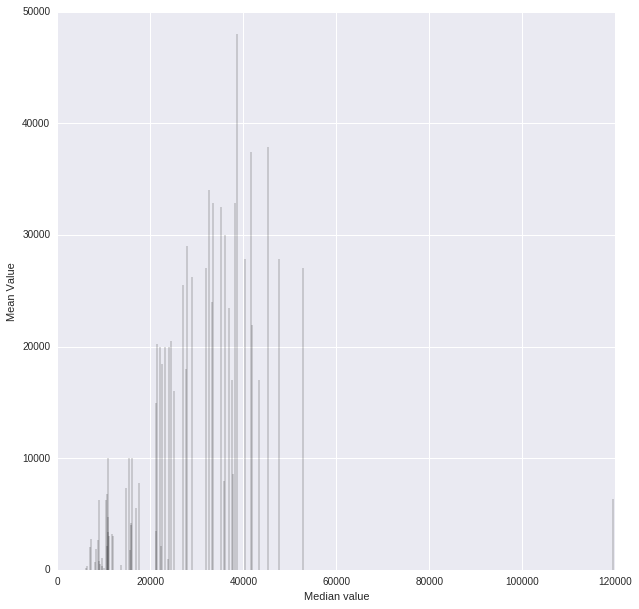

In [36]:
ax = mpl.figure(figsize=(10,10))


ax = mpl.bar(mean_median['Mean'], mean_median['Median'])
mpl.xlabel('Median value')
mpl.ylabel('Mean Value')

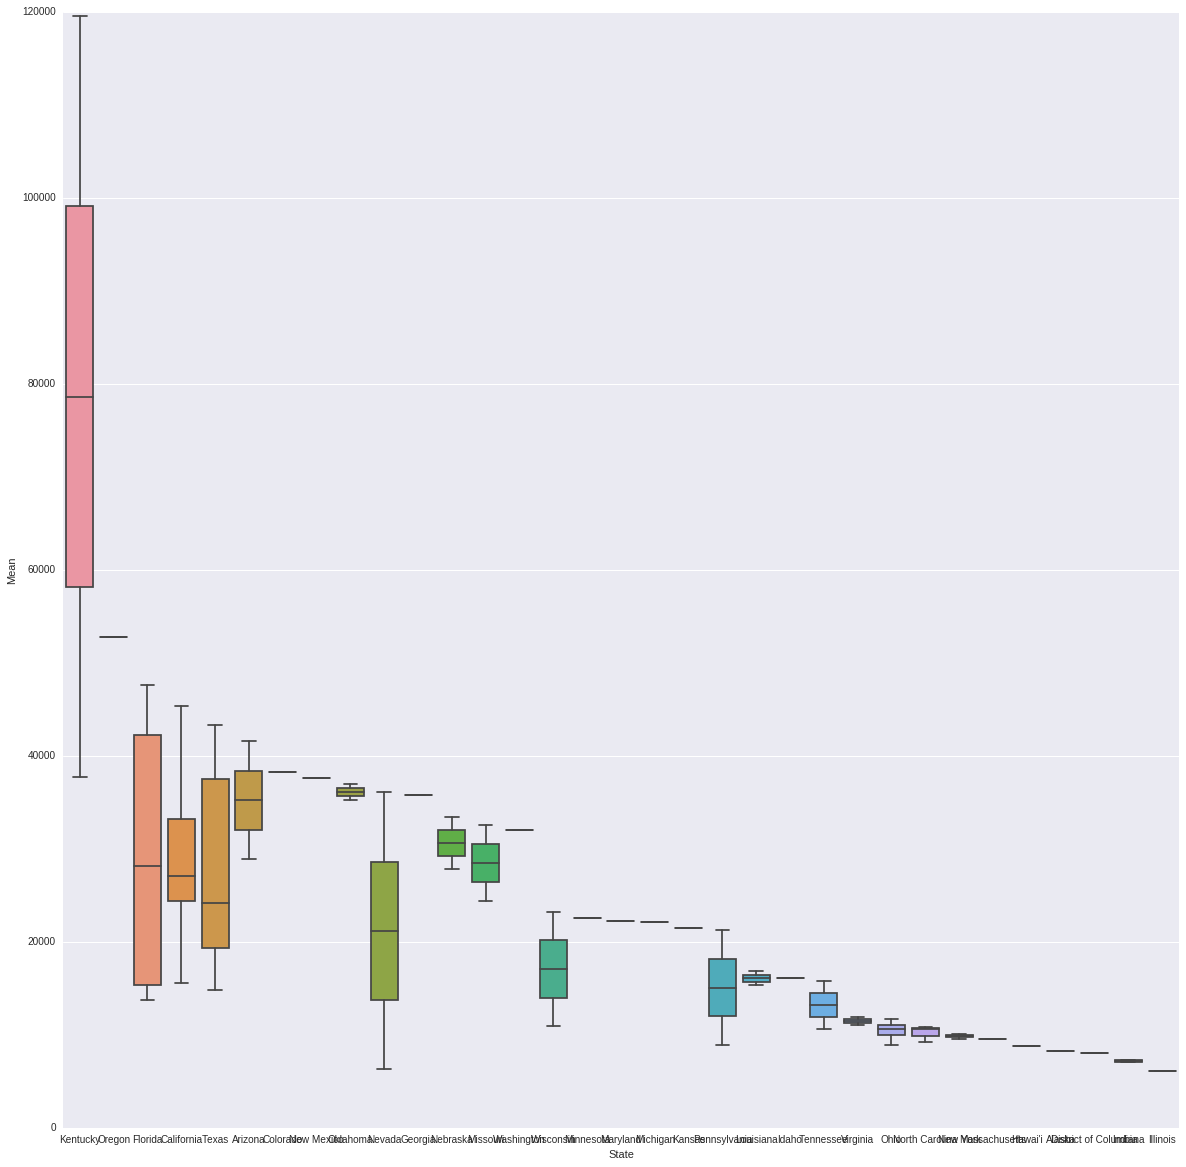

In [37]:
ax = mpl.figure(figsize=(20,20))
ax = sns.boxplot(mean_median['State'], mean_median['Mean'])

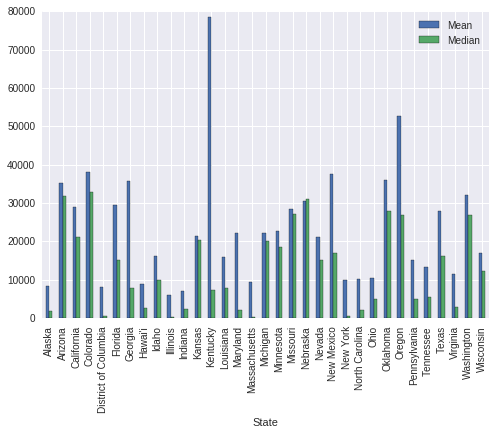

In [38]:
stuff = mean_median.groupby(['State']).apply(np.mean).plot(kind='bar')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.1 Does it makes sense to buy RVs in one region and sell them in another?

Assuming the cost of shipping or driving from one regional market to another.

In [ ]:
'''
When  it comes to  regional markets i dont think it would make much sense to do so. Taking into account
the cost of  shipping or the cost of  driving time also costs money and thus your margin of profit would be so 
miniscule because of the minor differences between rvs of the same caliber, between regions. In terms of local
markets, however, the mean for some cities within the same state was signifigantly different; this could be 
because there is an add which is either false in the price it provided for it's feature in the search
results, or because the market is actually different by a signifigant amount, nonetheless, only under the case of
the markets in question residing under the same state, would purchasing RVs and flipping them nearby, make sense.
'''

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.2 Can you pull out the "make" from the markup and include that in your analyis?
How reliable is this data and does it make sense?

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 5.3 Are there any other variables you could pull out of the markup to help describe your dataset?

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Move your project into scrapy (if you haven't used Scrapy yet)

>Start a project by using the command `scrapy startproject [projectname]`
> - Update your settings.py (review our past example)
> - Update your items.py
> - Create a spiders file in your `[project_name]/[project_name]/spiders` directory

You can update your spider class with the complete list of craigslist "start urls" to effectively scrape all of the regions.  Start with one to test.

Updating your parse method with the method you chose should require minimal changes.  It will require you to update your parse method to use the response parameter, and an item model (defined in items.py).

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7.  Chose another area of Craigslist to scrape.

**Choose an area having more than a single page of results, then scrape multiple regions, multiple pages of search results and or details pages.**

This is the true exercise of being able to understand how to succesffuly plan, develop, and employ a broader scraping strategy.  Even though this seems like a challenging task, a few tweeks of your current code can make this very managable if you've pieced together all the touch points.  If you are still confused as to some of the milestones within this process, this is an excellent opportunity to round out your understanding, or help you build a list of questions to fill in your gaps.

_Use Scrapy!  Provide your code in this project directory when you submit this project._